## Preprocess

In [2]:
import jsonlines
import pandas
import json
# Load the data from the JSON line file
with open('../data/kotlin-practice.jsonl', 'r') as f:
    dataframe = pandas.DataFrame([json.loads(line) for line in f])

In [3]:
dataframe.head()

,id,repo,revision,path,modified,prefix,suffix,archive
0,0d19dd,LinkSheet/LinkSheet,11d221b76b2fe40c589c4e44d9706b0c9fd11cd0,app/src/main/java/fe/linksheet/module/resolver...,[app/src/main/java/fe/linksheet/module/resolve...,package fe.linksheet.module.resolver\n\nimport...,"\n return map.mapNotNull { (_, activity...",LinkSheet__LinkSheet-11d221b76b2fe40c589c4e44d...
1,046696,LinkSheet/LinkSheet,1af0ed9ad6d3b790589b537cb32284c8c2d64ff6,app/src/main/java/fe/linksheet/composable/comp...,[app/src/main/java/fe/linksheet/activity/Botto...,package fe.linksheet.composable.component.list...,"checked = preference,\n onCheck...",LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb...
2,a508ff,LinkSheet/LinkSheet,25ef07550aea5ddff12f5af7c1b94f1f5ccd3df3,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/java/fe/linksheet/activity/Botto...,package fe.linksheet.composable.settings.botto...,}\n }\n }\n},LinkSheet__LinkSheet-25ef07550aea5ddff12f5af7c...
3,c2fddc,LinkSheet/LinkSheet,312d245779c6e4f3066887a1d83ba33aa8b9db60,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/java/com/tasomaniac/openwith/res...,package fe.linksheet.composable.settings\n\nim...,\n fun getUsageStatsAllowed(context: Contex...,LinkSheet__LinkSheet-312d245779c6e4f3066887a1d...
4,85e922,LinkSheet/LinkSheet,363391105db1b6d378189e8687f162a865b74a44,app/src/main/java/fe/linksheet/InterconnectSer...,[app/src/main/java/fe/linksheet/InterconnectSe...,package fe.linksheet\n\nimport android.app.Ser...,}\n }\n }\n\n overrid...,LinkSheet__LinkSheet-363391105db1b6d378189e868...


In [4]:
import os
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
DATA_ROOT = "../data/repositories-kotlin-practice/"



def extract_original_code_from_row(row: pandas.Series) -> str:
    """
    Extract the original code from the file path.
    """
    repo_path = os.path.join(DATA_ROOT, "-".join([row["repo"].replace("/", "__"), row['revision']]))
    file_path = repo_path + "/" + row['path']
    with open(file_path, 'r') as file:
        content = file.read()
    return content

dataframe['original_code'] = dataframe.apply(extract_original_code_from_row, axis=1)
dataframe['incomplete_code'] = dataframe.apply(lambda row: SEPARATOR_COMMENT.join([row['prefix'], row['suffix']]), axis=1)


In [22]:
import diff_match_patch

def extract_diff_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the diff from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.diff_lineMode(original_code, incomplete_code, deadline=None)
    # Convert the diffs to a single diff string
    diffs = "\n".join([diff[1] for diff in diffs if diff[0] != 0])
    return diffs

def extract_patch_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the patch from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.patch_make(original_code, incomplete_code)
    # Convert the patches to a single patch string
    patches = dmp.patch_toText(diffs)
    return patches


In [23]:
for index, row in dataframe.iterrows():
    output_root = "../samples-practice/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    dir_name = os.path.join(output_root, repo_revision)
    os.makedirs(dir_name, exist_ok=True)
    original_file_path = os.path.join(dir_name, "original.kt")
    incomplete_file_path = os.path.join(dir_name, "incomplete.kt")
    diff_file_path = os.path.join(dir_name, "diff.diff")
    patch_file_path = os.path.join(dir_name, "patch.patch")
    
    
    with open(original_file_path, 'w') as original_file:
        original_file.write(row['original_code'])
    with open(incomplete_file_path, 'w') as incomplete_file:
        incomplete_file.write(row['incomplete_code'])
    with open(diff_file_path, 'w') as diff_file:
        diff_file.write(extract_diff_from_original_code_and_incomplete_code(row))
    with open(patch_file_path, 'w') as patch_file:
        patch_file.write(extract_patch_from_original_code_and_incomplete_code(row))
    
    dataframe.at[index, 'diff'] = extract_diff_from_original_code_and_incomplete_code(row)
    dataframe.at[index, 'patch'] = extract_patch_from_original_code_and_incomplete_code(row)

        
        


## Syntax tree analysis

In [24]:
# Let's create a simple example to demonstrate the tree-sitter query matching
import tree_sitter
from tree_sitter_languages import get_language
# Sample Kotlin code
kotlin_code = """
class Person(val name: String) {
    var age: Int = 0
    
    fun getInfo(): String {
        return "Name: $name, Age: $age"
    }
    
    // This is a comment
    @Override
    fun toString() = "Person(name=$name)"
}
"""

# Create a parser
parser = tree_sitter.Parser()
parser.set_language(get_language("kotlin"))

# Parse the code
tree = parser.parse(bytes(kotlin_code, "utf8"))

# Print the syntax tree
print(tree.root_node.sexp())

(source_file (class_declaration name: (type_identifier) primary_constructor: (primary_constructor parameters: (class_parameter (simple_identifier) (user_type (type_identifier)))) body: (class_body (property_declaration variable: (variable_declaration (simple_identifier) (user_type (type_identifier))) expression: (integer_literal)) (function_declaration name: (simple_identifier) parameters: (function_value_parameters) return_type: (user_type (type_identifier)) body: (function_body (statements (jump_expression (string_literal (interpolated_identifier) (interpolated_identifier)))))) (line_comment) (function_declaration modifiers: (modifiers (annotation (user_type (type_identifier)))) name: (simple_identifier) parameters: (function_value_parameters) body: (function_body (string_literal (interpolated_identifier)))))))


In [25]:
def highlight_matches(code: str, query_string: str):
    """
    Highlight matches from a tree-sitter query in the given code
    """
    # Create a query
    language = get_language("kotlin")
    query = language.query(query_string)
    
    # Get matches
    tree = parser.parse(bytes(code, "utf8"))
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return
    
    
    # Print matches with their capture types
    for match in matches:
        print(match)

In [26]:
# Let's try some specific queries

# Find all function declarations
function_query = """
(function_declaration 
    . (simple_identifier) @function_name) @function
"""
print("Function declarations:")
highlight_matches(kotlin_code, function_query)

# Find class declarations
class_query = """(class_declaration
    (simple_identifier) @class_name) @class
"""

# Find class properties
property_query = """
(class_parameter
    (simple_identifier) @property)
(class_body
    (property_declaration
        (variable_declaration
            (simple_identifier) @property)))
"""
print("\nProperties:")
highlight_matches(kotlin_code, property_query)

Function declarations:
(<Node type=function_declaration, start_point=(4, 4), end_point=(6, 5)>, 'function')
(<Node type=simple_identifier, start_point=(4, 8), end_point=(4, 15)>, 'function_name')
(<Node type=function_declaration, start_point=(9, 4), end_point=(10, 41)>, 'function')

Properties:
(<Node type=simple_identifier, start_point=(1, 17), end_point=(1, 21)>, 'property')
(<Node type=simple_identifier, start_point=(2, 8), end_point=(2, 11)>, 'property')


In [27]:
# Function to analyze package and import relationships
def analyze_package_imports(code: str) -> tuple[str, list[str]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    
    # Parse the code
    language = get_language("kotlin")
    tree = parser.parse(bytes(code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node.text.decode("utf-8"))

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[str]) -> list[str]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.split('.')[0] == root_package
    ]
    
    return same_repo_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports:")
for imp in imports:
    print(f"  {imp}")

same_repo_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp}")

Package: fe.linksheet.module.resolver

Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat


## Token-level Analysis

In [28]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("JetBrains/Mellum-4b-sft-kotlin")


In [29]:
print(tokenizer.encode(kotlin_code))

[225, 925, 15970, 34, 841, 517, 52, 1269, 35, 339, 225, 247, 247, 247, 924, 5522, 52, 1410, 306, 369, 225, 225, 247, 247, 247, 4131, 779, 1243, 3161, 1269, 339, 225, 247, 247, 247, 247, 247, 247, 247, 545, 327, 574, 52, 427, 380, 38, 14369, 52, 427, 471, 28, 225, 247, 247, 247, 367, 225, 225, 247, 247, 247, 521, 1461, 432, 283, 5617, 225, 247, 247, 247, 583, 2944, 225, 247, 247, 247, 4131, 17956, 403, 306, 327, 9512, 34, 380, 5050, 380, 2324, 225, 119, 225]


In [30]:
def code_to_tokens(code: str | list[str]) -> list[int]:
    """
    Convert code to tokens using the tokenizer
    """
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    if isinstance(code, list):
        return [token for snippet in cleaned_code for token in tokenizer.encode(snippet)]
    return tokenizer.encode(cleaned_code)

dataframe['num_prefix_tokens'] = dataframe['prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens'] = dataframe['suffix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_diff_tokens'] = dataframe['diff'].apply(lambda x : len(code_to_tokens(x)))

In [31]:
dataframe[['num_prefix_tokens', 'num_suffix_tokens', 'num_diff_tokens']].head()

,num_prefix_tokens,num_suffix_tokens,num_diff_tokens
0,417,202,98
1,692,112,303
2,3432,28,135
3,2239,712,238
4,1239,332,50


Text(0, 0.5, 'Frequency')

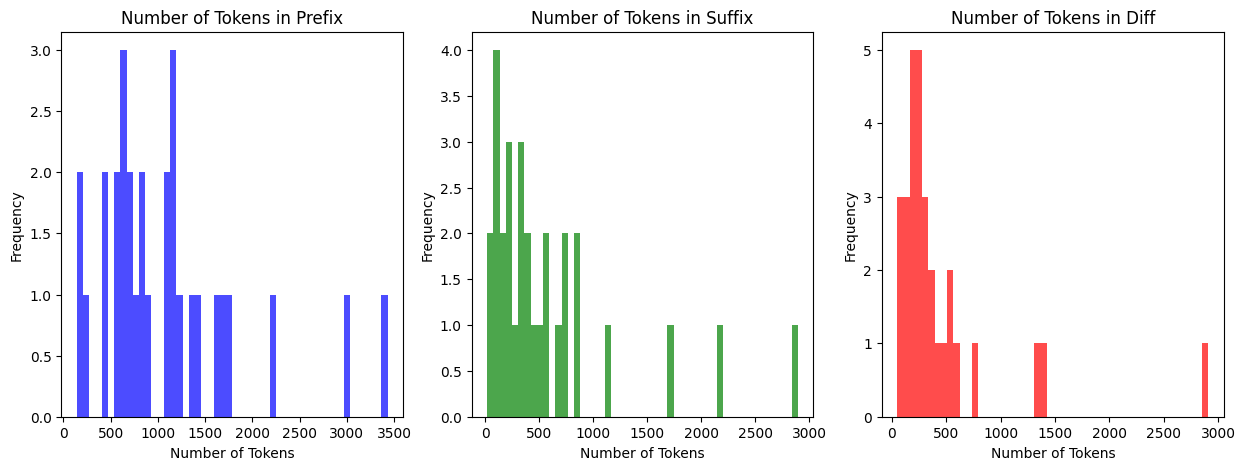

In [32]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [33]:
def remove_comments_nodes(code: str)->str:
    """
    Remove comments from the code using tree-sitter
    """
    language = get_language("kotlin")
    parser = tree_sitter.Parser()
    parser.set_language(language)
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    # Parse the code
    tree = parser.parse(bytes(cleaned_code, "utf8"))

    # Query to find comment nodes
    query_str = """
    (line_comment) @comment
    (multiline_comment) @comment
    """
    
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    
    # Remove comment nodes from the code
    
    for match in matches:
        node = match[0]
        cleaned_code = cleaned_code[:node.start_byte] + cleaned_code[node.end_byte:]

    return cleaned_code

dataframe['prefix_without_comments'] = dataframe['prefix'].apply(
    remove_comments_nodes
)

dataframe['suffix_without_comments'] = dataframe['suffix'].apply(
    remove_comments_nodes
)
dataframe['diff_without_comments'] = dataframe['diff'].apply(
    remove_comments_nodes
)



Text(0.5, 1.0, 'Number of Tokens in Diff')

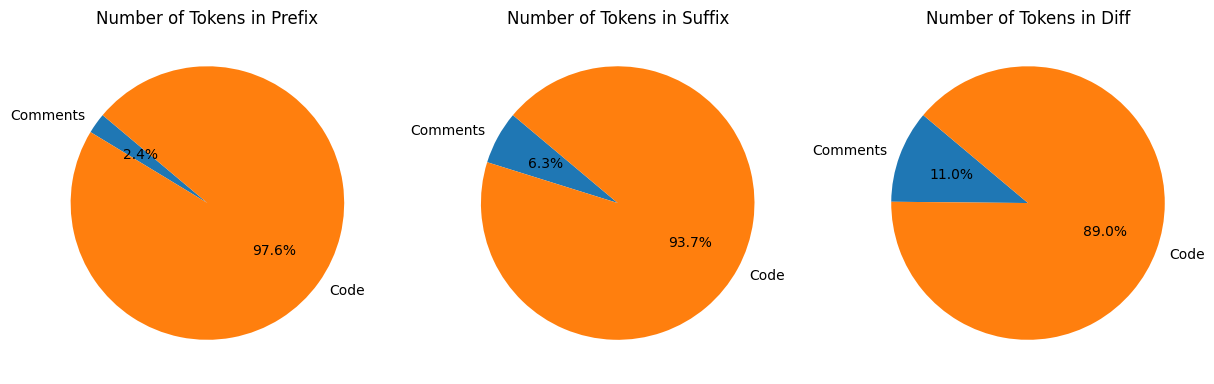

In [34]:
dataframe["num_prefix_tokens_without_comments"] = dataframe['prefix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_suffix_tokens_without_comments"] = dataframe['suffix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_diff_tokens_without_comments"] = dataframe['diff_without_comments'].apply(lambda x : len(code_to_tokens(x)))

# plot 3 pie charts of the number of tokens  between code and comments (original - code) in prefix, suffix, and diff

import matplotlib.pyplot as plt

labels = ['Comments', 'Code']
prefix_sizes = [
    dataframe['num_prefix_tokens'].sum() - dataframe['num_prefix_tokens_without_comments'].sum(),
    dataframe['num_prefix_tokens_without_comments'].sum()
]
suffix_sizes = [
    dataframe['num_suffix_tokens'].sum() - dataframe['num_suffix_tokens_without_comments'].sum(),
    dataframe['num_suffix_tokens_without_comments'].sum()
]
diff_sizes = [
    dataframe['num_diff_tokens'].sum() - dataframe['num_diff_tokens_without_comments'].sum(),
    dataframe['num_diff_tokens_without_comments'].sum()
]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pie(prefix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Prefix')
plt.subplot(1, 3, 2)
plt.pie(suffix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Suffix')
plt.subplot(1, 3, 3)
plt.pie(diff_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Diff')


Text(0, 0.5, 'Frequency')

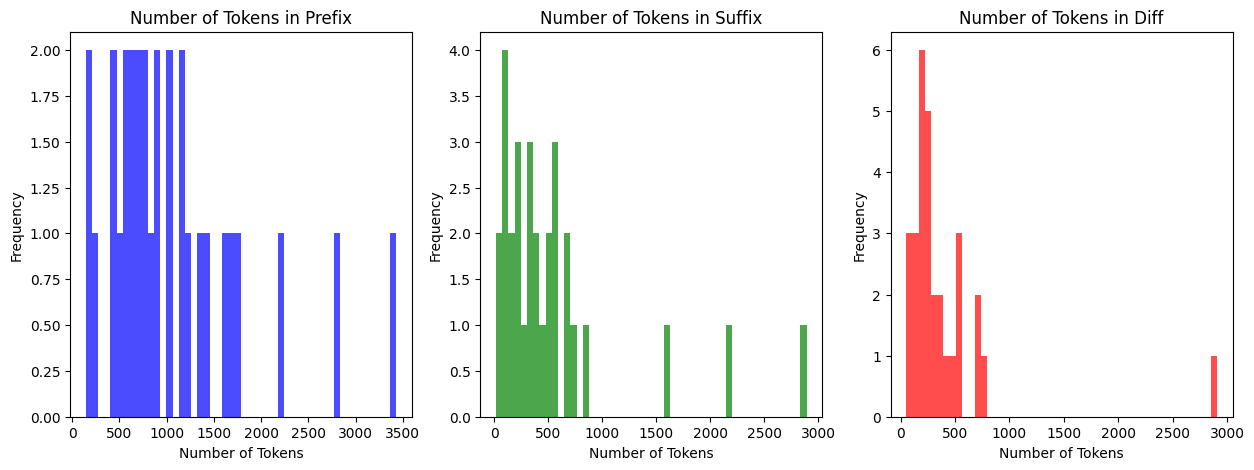

In [35]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff (after removing comments)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_without_comments'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens_without_comments'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens_without_comments'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [36]:
# Function to analyze package and import relationships
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
def analyze_package_imports(code: str) -> tuple[str, list[Node]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    parser = get_parser("kotlin")
    # Parse the code
    language = get_language("kotlin")
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(cleaned_code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node)

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[Node]) -> list[Node]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] == root_package
    ]
    external_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] != root_package
    ]

    return same_repo_imports, external_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")

same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")

def remove_import_nodes(code: str, import_nodes: list[Node]) -> str:
    """
    Remove import statements from the code using tree-sitter
    """
    for node in import_nodes:
        code = code[:node.start_byte] + code[node.end_byte:]

    return code



for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")

print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}")


# A function to at the same time identify pakage name, extract in-repository and external imports, and remove import nodes from prefix
def analyze_and_clean_imports(code: str) -> tuple[str, list[str], list[str], str]:
    """
    Analyze the code to extract package name, in-repository imports, external imports,
    and return the cleaned code without import statements.
    """
    package_name, imports = analyze_package_imports(code)
    same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
    cleaned_code = remove_import_nodes(code, same_repo_imports)
    return package_name, same_repo_imports, external_imports, cleaned_code

package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")
print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}") 
print("\nCleaned Code:")


Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri

Cleaned Code:


In [37]:
for index, row in dataframe.iterrows():
    package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(row.prefix)
    dataframe.at[index, 'package_name'] = package_name
    dataframe.at[index, 'same_repo_imports'] = [imp.text.decode('utf-8') for imp in same_repo_imports]
    dataframe.at[index, 'external_imports'] = [imp.text.decode('utf-8') for imp in external_imports]
    dataframe.at[index, 'prefix_without_imports'] = cleaned_code

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
# pie charts of the number of imports in same repository and external imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(len).sum()
external_counts = dataframe['external_imports'].apply(len).sum()
sizes = [same_repo_counts, external_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

KeyError: 'external_imports'

In [38]:
# pie charts of the number of tokens of imports in same repository and external imports, and the prefix without imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports', 'Prefix Without Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
external_counts = dataframe['external_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
prefix_counts = dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
sizes = [same_repo_counts, external_counts, prefix_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

AttributeError: 'list' object has no attribute 'replace'

KeyError: 'prefix_without_imports'

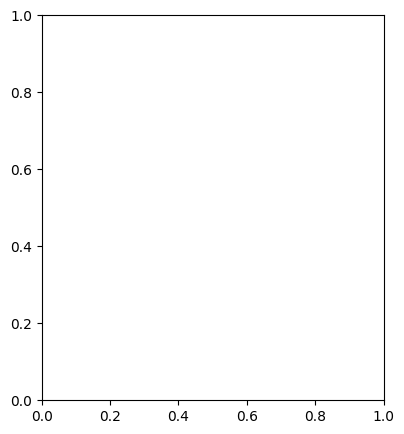

In [39]:
# 3 histograms of the number of tokens in prefix (after removing imports), suffix, and diff 
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))), bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [40]:
dataframe.head()

,id,repo,revision,path,modified,prefix,suffix,archive,original_code,incomplete_code,...,num_diff_tokens,prefix_without_comments,suffix_without_comments,diff_without_comments,num_prefix_tokens_without_comments,num_suffix_tokens_without_comments,num_diff_tokens_without_comments,package_name,same_repo_imports,external_imports
0,0d19dd,LinkSheet/LinkSheet,11d221b76b2fe40c589c4e44d9706b0c9fd11cd0,app/src/main/java/fe/linksheet/module/resolver...,[app/src/main/java/fe/linksheet/module/resolve...,package fe.linksheet.module.resolver\n\nimport...,"\n return map.mapNotNull { (_, activity...",LinkSheet__LinkSheet-11d221b76b2fe40c589c4e44d...,package fe.linksheet.module.resolver\n\nimport...,package fe.linksheet.module.resolver\n\nimport...,...,98,package fe.linksheet.module.resolver\n\nimport...,"\n return map.mapNotNull { (_, activity...",\n\n return deduplicate(filtered)\n ...,417,202,98,fe.linksheet.module.resolver,"[fe.linksheet.util.BitFlagUtil, fe.linksheet.u...",nan
1,046696,LinkSheet/LinkSheet,1af0ed9ad6d3b790589b537cb32284c8c2d64ff6,app/src/main/java/fe/linksheet/composable/comp...,[app/src/main/java/fe/linksheet/activity/Botto...,package fe.linksheet.composable.component.list...,"checked = preference,\n onCheck...",LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb...,package fe.linksheet.composable.component.list...,package fe.linksheet.composable.component.list...,...,303,package fe.linksheet.composable.component.list...,"checked = preference,\n onCheck...",\n\n@Composable\nfun PreferenceDividedSwitchLi...,692,112,303,NaN,nan,nan
2,a508ff,LinkSheet/LinkSheet,25ef07550aea5ddff12f5af7c1b94f1f5ccd3df3,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/java/fe/linksheet/activity/Botto...,package fe.linksheet.composable.settings.botto...,}\n }\n }\n},LinkSheet__LinkSheet-25ef07550aea5ddff12f5af7c...,package fe.linksheet.composable.settings.botto...,package fe.linksheet.composable.settings.botto...,...,135,package fe.linksheet.composable.settings.botto...,}\n }\n }\n},"\n\n item(key = ""enable_request_pri...",3432,28,135,NaN,nan,nan
3,c2fddc,LinkSheet/LinkSheet,312d245779c6e4f3066887a1d83ba33aa8b9db60,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/java/com/tasomaniac/openwith/res...,package fe.linksheet.composable.settings\n\nim...,\n fun getUsageStatsAllowed(context: Contex...,LinkSheet__LinkSheet-312d245779c6e4f3066887a1d...,package fe.linksheet.composable.settings\n\nim...,package fe.linksheet.composable.settings\n\nim...,...,238,package fe.linksheet.composable.settings\n\nim...,\n fun getUsageStatsAllowed(context: Contex...,fun onUsageStatsSorting(it: Boolean) {\n ...,2239,510,238,NaN,nan,nan
4,85e922,LinkSheet/LinkSheet,363391105db1b6d378189e8687f162a865b74a44,app/src/main/java/fe/linksheet/InterconnectSer...,[app/src/main/java/fe/linksheet/InterconnectSe...,package fe.linksheet\n\nimport android.app.Ser...,}\n }\n }\n\n overrid...,LinkSheet__LinkSheet-363391105db1b6d378189e868...,package fe.linksheet\n\nimport android.app.Ser...,package fe.linksheet\n\nimport android.app.Ser...,...,50,package fe.linksheet\n\nimport android.app.Ser...,}\n }\n }\n\n overrid...,\n\n override fun selectDomainsWith...,1239,332,50,NaN,nan,nan


### Localize Completion Point

In [ ]:
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
# using tree-sitter to find multi-line comment nodes in the diff
import re
import pandas
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
def detect_completion_point(row) -> tuple[int, int]:
    """
    Detect the completion point by taking the end point of the prefix.
    """
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(row["prefix"], "utf8"))
    return tree.root_node.end_point

def localize_outer_symbol_from_completion_point(row: pandas.Series) -> tuple[Node, str]:
    """
    Find the innermost symbol declaration that contains the completion point.
    """
    parser = get_parser("kotlin")
    incomplete_code = row["incomplete_code"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    
    with open("../kotlin_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("kotlin").query(query_str)

    matches = query.captures(tree.root_node)
    declarations = [(node, node_type) for node, node_type in matches if "declaration" in node_type]
    
    completion_point = detect_completion_point(row)
    
    # Find all declarations that contain the completion point
    containing_declarations = []
    for node, node_type in declarations:
        if (node.start_point <= completion_point <= node.end_point):
            print(f"Node: {node.text.decode('utf-8')}, Type: {node_type}, Start: {node.start_point}, End: {node.end_point}, Completion Point: {completion_point}")
            containing_declarations.append((node, node_type))
    
    if not containing_declarations:
        # get neigj
        return None, None
    
    # Return the innermost (latest starting) declaration
    return max(containing_declarations, key=lambda x: x[0].start_point)

In [197]:
dataframe['completion_point'] = dataframe.apply(detect_completion_point, axis=1)

In [198]:
outer_symbol = localize_outer_symbol_from_completion_point(dataframe.iloc[1])

Node: @Composable
fun PreferenceDividedSwitchListItem(
    enabled: EnabledContentSet = EnabledContent.all,
    statePreference: ViewModelStatePreference<Boolean, Boolean, Preference.Default<Boolean>>,
    onContentClick: () -> Unit,
    shape: Shape = CustomShapeDefaults.SingleShape,
    padding: PaddingValues = CommonDefaults.EmptyPadding,
    headlineContent: TextContent,
    overlineContent: TextContent? = null,
    supportingContent: TextContent? = null,
    otherContent: OptionalContent = null,
) {
    val preference = statePreference.collectAsStateWithLifecycle()

    DividedSwitchListItem(
        enabled = enabled,
        shape         checked = preference,
        onCheckedChange = { statePreference.update(it) },
        onContentClick = onContentClick,
        overlineContent = overlineContent,
        headlineContent = headlineContent,
        supportingContent = supportingContent,
        otherContent = otherContent
    )
}, Type: function.declaration, Start: (44, 0), End

In [199]:
outer_symbol[0].text.decode("utf-8"), outer_symbol[0].start_point, outer_symbol[0].end_point, outer_symbol[1]

('DividedSwitchListItem(\n        enabled = enabled,\n        shape         checked = preference,\n        onCheckedChange = { statePreference.update(it) },\n        onContentClick = onContentClick,\n        overlineContent = overlineContent,\n        headlineContent = headlineContent,\n        supportingContent = supportingContent,\n        otherContent = otherContent\n    )',
 (58, 4),
 (67, 5),
 'function.declaration')

In [200]:
for index, row in dataframe.iterrows():
   outer_symbol = localize_outer_symbol_from_completion_point(row)
   if not outer_symbol[0]:
       print(f"No outer symbol found for row {index}")
       continue
   dataframe.at[index, 'container_symbol'] = outer_symbol[0].text.decode("utf-8") if outer_symbol else None
   dataframe.at[index, 'container_symbol_type'] = outer_symbol[0].type if outer_symbol else None

Node: object PackageHandler {
    private val QUERY_FLAGS = BitFlagUtil.or(
        PackageManager.MATCH_ALL,
        PackageManager.GET_RESOLVED_FILTER,
        PackageManager.MATCH_DISABLED_COMPONENTS,
        PackageManager.GET_META_DATA
    )

    fun findHandlers(context: Context, uri: Uri): List<ResolveInfo> {
        val viewIntent = Intent(Intent.ACTION_VIEW, uri).addCategory(Intent.CATEGORY_BROWSABLE)
        val activities = context.packageManager.queryIntentActivitiesCompat(viewIntent, QUERY_FLAGS)

        return activities.filter {
            it.activityInfo.applicationInfo.enabled && !LinkSheetCompat.isCompat(it) && isLinkHandler(it.filter, uri)
        }

        return deduplicate(filtered)
    }

    private fun deduplicate(filtered: List<ResolveInfo>): List<ResolveInfo> {
        val map = mutableMapOf<String, ActivityAlias>()
        f
        return map.mapNotNull { (_, activity) -> activity.get() }
    }

    fun isLinkHandler(filter: IntentFilter, uri: Uri): Bool

In [80]:
localize_outer_symbol_from_completion_point(dataframe.iloc[1291])

IndexError: single positional indexer is out-of-bounds

In [82]:
dataframe.iloc[29]

id                                                                               86e27d
repo                                                                LinkSheet/LinkSheet
revision                                       f7c08103416b4a93a8536c55741d486919f8e243
path                                  app/src/main/java/fe/linksheet/composable/page...
modified                              [app/src/main/java/fe/linksheet/Route.kt, app/...
prefix                                package fe.linksheet.composable.page.main\n\ni...
suffix                                \n        Spacer(Modifier.size(ButtonDefaults....
archive                               LinkSheet__LinkSheet-f7c08103416b4a93a8536c557...
original_code                         package fe.linksheet.composable.page.main\n\ni...
incomplete_code                       package fe.linksheet.composable.page.main\n\ni...
diff                                  \n@Composable\nprivate fun EditButton(\n    @S...
patch                           

In [ ]:
dataframe['container_symbol_type'].value_counts()

container_symbol_type
call_expression         16
function_declaration     8
class_declaration        3
type_alias               2
object_declaration       1
Name: count, dtype: int64

<Axes: title={'center': 'Container Symbol Type Distribution'}, ylabel='count'>

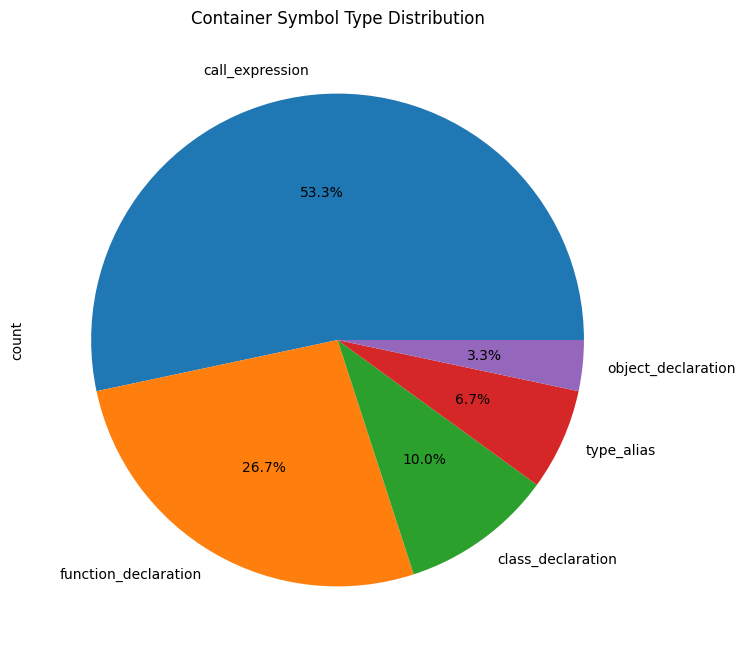

In [ ]:

dataframe['container_symbol_type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Container Symbol Type Distribution')

In [ ]:
def code_to_tokens(code: str | list[str]) -> list[int]:
    """
    Convert code to tokens using the tokenizer
    """
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    if isinstance(code, list):
        return [token for snippet in cleaned_code for token in tokenizer.encode(snippet)]
    return tokenizer.encode(cleaned_code)

dataframe['num_tokens_container_symbol'] = dataframe['container_symbol'].apply(lambda x: len(code_to_tokens(x)))

<Axes: >

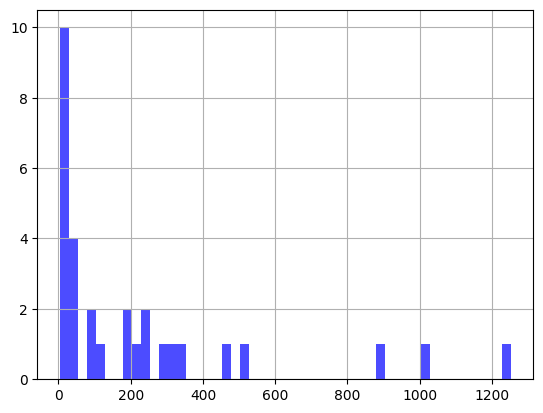

In [ ]:
dataframe['num_tokens_container_symbol'].hist(bins=50, color='blue', alpha=0.7)

In [ ]:
dataframe['num_tokens_container_symbol'].value_counts()

num_tokens_container_symbol
80      2
6       2
10      2
511     1
284     1
11      1
350     1
39      1
1252    1
23      1
24      1
896     1
469     1
15      1
38      1
215     1
50      1
310     1
4       1
47      1
28      1
123     1
188     1
237     1
182     1
1026    1
231     1
Name: count, dtype: int64

In [166]:
dataframe[dataframe['num_tokens_container_symbol']<10]["container_symbol_type"].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Container Symbol Type Distribution (Tokens < 10)')

KeyError: 'num_tokens_container_symbol'

In [85]:
dataframe[dataframe['num_tokens_container_symbol']<10]

,id,repo,revision,path,modified,prefix,suffix,archive,original_code,incomplete_code,...,diff_without_comments,num_prefix_tokens_without_comments,num_suffix_tokens_without_comments,num_diff_tokens_without_comments,package_name,same_repo_imports,completion_point,container_symbol,container_symbol_type,num_tokens_container_symbol
3,c2fddc,LinkSheet/LinkSheet,312d245779c6e4f3066887a1d83ba33aa8b9db60,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/java/com/tasomaniac/openwith/res...,package fe.linksheet.composable.settings\n\nim...,\n fun getUsageStatsAllowed(context: Contex...,LinkSheet__LinkSheet-312d245779c6e4f3066887a1d...,package fe.linksheet.composable.settings\n\nim...,package fe.linksheet.composable.settings\n\nim...,...,fun onUsageStatsSorting(it: Boolean) {\n ...,2239,510,238,NaN,nan,"(148, 22)",inject<LinkSheetDatabase>(),call_expression,6
12,ab70af,LinkSheet/LinkSheet,810d178cae37dc37c2735648a7ad85094a3b71c5,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/experiment/fe/linksheet/experime...,package fe.linksheet.composable.settings.theme...,}\n\n item(key = R.stri...,LinkSheet__LinkSheet-810d178cae37dc37c2735648a...,package fe.linksheet.composable.settings.theme...,package fe.linksheet.composable.settings.theme...,...,"\n\n item(key = ""mode"", contentType...",772,2894,2908,NaN,nan,"(53, 58)",koinViewModel(),call_expression,4
16,13774e,LinkSheet/LinkSheet,a026a911b1940b8e766664a2eb03b3df1dda91c4,app/src/main/java/fe/linksheet/activity/bottom...,[app/src/main/java/fe/linksheet/LinkSheetApp.k...,package fe.linksheet.activity.bottomsheet\n\ni...,\n\n\n// if (preview.description !=...,LinkSheet__LinkSheet-a026a911b1940b8e766664a2e...,package fe.linksheet.activity.bottomsheet\n\ni...,package fe.linksheet.activity.bottomsheet\n\ni...,...,\n unfurlResult?.let { preview ->\n ...,998,1605,680,NaN,nan,"(73, 54)",preview.thumbnail.toString(),call_expression,6


In [167]:
import pandas as pd
dataframe  = pd.read_csv("../data/kotlin_practice_analyzed.csv")

In [86]:
dataframe['num_diff_tokens'].median()

np.float64(257.0)

In [93]:
dataframe.to_csv("../data/kotlin_practice_analyzed.csv", index=False)

## Diff Analysis

### Answer analysis


In [84]:
import jsonlines

answers_batch = []

with jsonlines.open('../data/answers-kotlin-practice.jsonl', 'r') as reader:
    for obj in reader:
        answers_batch.append(obj['middle'])


In [85]:
tokenized_answers = [code_to_tokens(answer) for answer in answers_batch]

In [86]:
dataframe['num_token_answers'] = [len(tokens) for tokens in tokenized_answers]

In [163]:
dataframe['num_token_answers'].max(
)

np.int64(279)

In [165]:
dataframe['diff_tokens'].max()

np.int64(2908)

### Zoekt


In [185]:
import requests
import json

url = "http://localhost:6070/api/search"

payload = json.dumps({
  "Q": "Icon imageVector Icons.Outlined.Edit r:LinkSheet__LinkSheet-",
  "Opts": {
    "NumContextLines": 5,
    "MaxResults": 10,
  }
})
headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)


{"Result":{"ContentBytesLoaded":126022,"IndexBytesLoaded":193898,"Crashes":0,"Duration":87580000,"FileCount":4,"ShardFilesConsidered":0,"FilesConsidered":59,"FilesLoaded":16,"FilesSkipped":0,"ShardsScanned":15,"ShardsSkipped":0,"ShardsSkippedFilter":15,"MatchCount":28,"NgramMatches":985,"NgramLookups":1299,"Wait":101750,"MatchTreeConstruction":387700129,"MatchTreeSearch":253438542,"RegexpsConsidered":16,"FlushReason":0,"Files":[{"FileName":"app/src/main/java/fe/linksheet/composable/page/home/card/OpenCopiedLink.kt","Repository":"LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb32284c8c2d64ff6","Language":"Kotlin","LineMatches":[{"Line":"ICAgICAgICBjb250ZW50UGFkZGluZyA9IEJ1dHRvbkRlZmF1bHRzLkJ1dHRvbldpdGhJY29uQ29udGVudFBhZGRpbmcK","LineStart":2422,"LineEnd":2491,"LineNumber":74,"Before":"ICAgIEBTdHJpbmdSZXMgaWQ6IEludCwKICAgIG9uQ2xpY2s6ICgpIC0+IFVuaXQsCikgewogICAgQnV0dG9uKAogICAgICAgIG9uQ2xpY2sgPSBvbkNsaWNrLAo=","After":"ICAgICkgewogICAgICAgIEljb24oCiAgICAgICAgICAgIGltYWdlVmVjdG9yID0gSWNvbnM

In [186]:

searched = response.json()

In [187]:
searched_files = searched['Result']['Files']

In [188]:
searched_files

[{'FileName': 'app/src/main/java/fe/linksheet/composable/page/home/card/OpenCopiedLink.kt',
  'Repository': 'LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb32284c8c2d64ff6',
  'Language': 'Kotlin',
  'LineMatches': [{'Line': 'ICAgICAgICBjb250ZW50UGFkZGluZyA9IEJ1dHRvbkRlZmF1bHRzLkJ1dHRvbldpdGhJY29uQ29udGVudFBhZGRpbmcK',
    'LineStart': 2422,
    'LineEnd': 2491,
    'LineNumber': 74,
    'Before': 'ICAgIEBTdHJpbmdSZXMgaWQ6IEludCwKICAgIG9uQ2xpY2s6ICgpIC0+IFVuaXQsCikgewogICAgQnV0dG9uKAogICAgICAgIG9uQ2xpY2sgPSBvbkNsaWNrLAo=',
    'After': 'ICAgICkgewogICAgICAgIEljb24oCiAgICAgICAgICAgIGltYWdlVmVjdG9yID0gSWNvbnMuT3V0bGluZWQuRWRpdCwKICAgICAgICAgICAgY29udGVudERlc2NyaXB0aW9uID0gbnVsbCwKICAgICAgICAgICAgbW9kaWZpZXIgPSBNb2RpZmllci5zaXplKEJ1dHRvbkRlZmF1bHRzLkljb25TaXplKQo=',
    'FileName': False,
    'Score': 500.7142857142857,
    'DebugScore': '',
    'LineFragments': [{'LineOffset': 50,
      'Offset': 2472,
      'MatchLength': 4,
      'SymbolInfo': None}]},
   {'Line': 'ICAgICAgICBJY29uKAo='

In [189]:
import base64

def decode_line(line: str) -> str:
    """
    Decode a base64 encoded line.
    """
    return base64.b64decode(line).decode('utf-8')

matches = searched_files[0]['LineMatches']
# matches.sort(key=lambda x: x['LineNumber'])
code_snippets = ["".join([decode_line(match['Before']), decode_line(match['Line']), decode_line(match['After'])]) for match in matches]

In [190]:
code_snippets

['    @StringRes id: Int,\n    onClick: () -> Unit,\n) {\n    Button(\n        onClick = onClick,\n        contentPadding = ButtonDefaults.ButtonWithIconContentPadding\n    ) {\n        Icon(\n            imageVector = Icons.Outlined.Edit,\n            contentDescription = null,\n            modifier = Modifier.size(ButtonDefaults.IconSize)\n',
 ') {\n    Button(\n        onClick = onClick,\n        contentPadding = ButtonDefaults.ButtonWithIconContentPadding\n    ) {\n        Icon(\n            imageVector = Icons.Outlined.Edit,\n            contentDescription = null,\n            modifier = Modifier.size(ButtonDefaults.IconSize)\n        )\n\n',
 '    Button(\n        onClick = onClick,\n        contentPadding = ButtonDefaults.ButtonWithIconContentPadding\n    ) {\n        Icon(\n            imageVector = Icons.Outlined.Edit,\n            contentDescription = null,\n            modifier = Modifier.size(ButtonDefaults.IconSize)\n        )\n\n        Spacer(Modifier.size(ButtonDefaults

In [191]:
code_snippets[0].split("\n")

['    @StringRes id: Int,',
 '    onClick: () -> Unit,',
 ') {',
 '    Button(',
 '        onClick = onClick,',
 '        contentPadding = ButtonDefaults.ButtonWithIconContentPadding',
 '    ) {',
 '        Icon(',
 '            imageVector = Icons.Outlined.Edit,',
 '            contentDescription = null,',
 '            modifier = Modifier.size(ButtonDefaults.IconSize)',
 '']

In [156]:
sum([len(code_to_tokens(code_snippet)) for code_snippet in code_snippets])

978

In [146]:
len(code_snippets)

7

In [193]:
#find the intersection of every code snippet in the code_snippets list
from functools import reduce
def find_intersection(snippets: list[str]) -> str:
    """
    Find the intersection of all code snippets.
    """
    if not snippets:
        return ""
    return reduce(lambda x, y: "".join(set(x) & set(y)), snippets)

In [154]:
decode_line(searched_files[0]['LineMatches'][0]['After'])

'import androidx.compose.material.icons.outlined.ContentPasteGo\nimport androidx.compose.material.icons.outlined.Edit\nimport androidx.compose.material3.*\nimport androidx.compose.runtime.Composable\nimport androidx.compose.runtime.remember\n'

In [ ]:
g